In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import optuna

# treat all python warnings as lower-level "ignore" events
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df= pd.read_csv("/content/drive/MyDrive/new data kerala.csv")

In [ ]:
df

,Mean Intensity,Duration,Label
0,5.278308,65,1
1,5.343077,13,1
2,3.869231,65,1
3,2.604286,14,1
4,4.261111,9,1
...,...,...,...
4139,0.950000,6,0
4140,0.400000,1,0
4141,1.670000,1,0
4142,4.346000,10,0


In [ ]:
df["Label"].value_counts()

,count
Label,
0,3636
1,508


In [ ]:
df["log_Mean_Intensity"] = np.log10(df["Mean Intensity"])
df["log_Duration"] = np.log10(df["Duration"])
print(df.shape)
df.head()

(4144, 5)


,Mean Intensity,Duration,Label,log_Mean_Intensity,log_Duration
0,5.278308,65,1,0.722495,1.812913
1,5.343077,13,1,0.727791,1.113943
2,3.869231,65,1,0.587625,1.812913
3,2.604286,14,1,0.415689,1.146128
4,4.261111,9,1,0.629523,0.954243


In [ ]:
X = df[["log_Duration", "log_Mean_Intensity"]]
y = df["Label"]

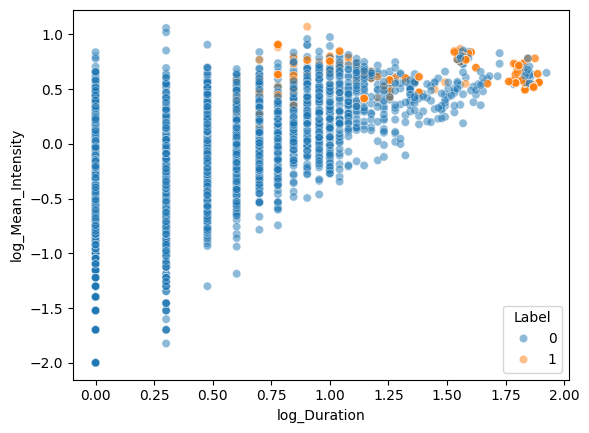

In [ ]:
sns.scatterplot(data=df, x="log_Duration", y="log_Mean_Intensity", hue="Label", alpha=0.5);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3315, 2), (829, 2), (3315,), (829,))

In [ ]:
X_train

,log_Duration,log_Mean_Intensity
3935,1.806180,0.713963
178,0.000000,0.113943
668,1.591065,0.839929
3334,0.000000,-0.022276
787,0.698970,0.405858
...,...,...
3444,0.000000,-0.698970
466,0.698970,-0.238072
3092,0.000000,-0.698970
3772,0.000000,0.225309


In [ ]:
triggered_index = y_train[y_train == 1].index

X_train_triggered = X[X.index.isin(triggered_index)]
y_train_triggered = y_train[y_train==1]
X_train_triggered.shape, y_train_triggered.shape

((408, 2), (408,))

## Support Vector Machine

In [ ]:
def objective(trial):
    params = {
        'C': trial.suggest_float("C", 0.1, 100),
        'kernel': trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_float("gamma", 0.1, 10)
    }

    model = SVC(**params, probability=True, random_state=0)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_train_triggered)

    acc = accuracy_score(y_train_triggered, y_pred)

    return acc

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = 'maximize' , study_name = 'SVM')
study.optimize(objective, n_trials = 100)

In [ ]:
study.best_params

{'C': 87.18672391214815, 'kernel': 'rbf', 'gamma': 1.6975125993818487}

In [ ]:
# Train the model with best hyperparameters
model = SVC(**study.best_params, probability=True, random_state=0)
model.fit(X_train, y_train)

SVC(C=87.18672391214815, gamma=1.6975125993818487, probability=True,
    random_state=0)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       727
           1       0.75      0.74      0.74       102

    accuracy                           0.94       829
   macro avg       0.86      0.85      0.85       829
weighted avg       0.94      0.94      0.94       829



In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[702,  27],
       [ 25,  75]])

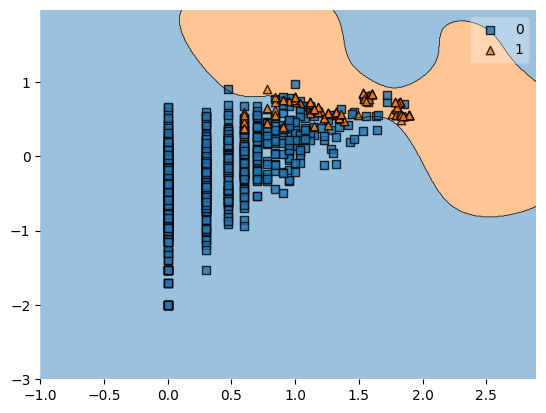

In [ ]:
plot_decision_regions(X_test.values, y_test.values, model);

In [ ]:
y_pred_all = model.predict(X)
y_pred_prob_all = model.predict_proba(X)[:, 1]
df["landslide_probability"] = y_pred_prob_all
df

,Mean Intensity,Duration,Label,log_Mean_Intensity,log_Duration,landslide_probability
0,5.278308,65,1,0.722495,1.812913,8.078539e-01
1,5.343077,13,1,0.727791,1.113943,7.264372e-01
2,3.869231,65,1,0.587625,1.812913,8.261482e-01
3,2.604286,14,1,0.415689,1.146128,9.214344e-02
4,4.261111,9,1,0.629523,0.954243,1.625410e-01
...,...,...,...,...,...,...
4139,0.950000,6,0,-0.022276,0.778151,7.255316e-02
4140,0.400000,1,0,-0.397940,0.000000,1.764910e-05
4141,1.670000,1,0,0.222716,0.000000,1.895517e-07
4142,4.346000,10,0,0.638090,1.000000,2.376744e-01


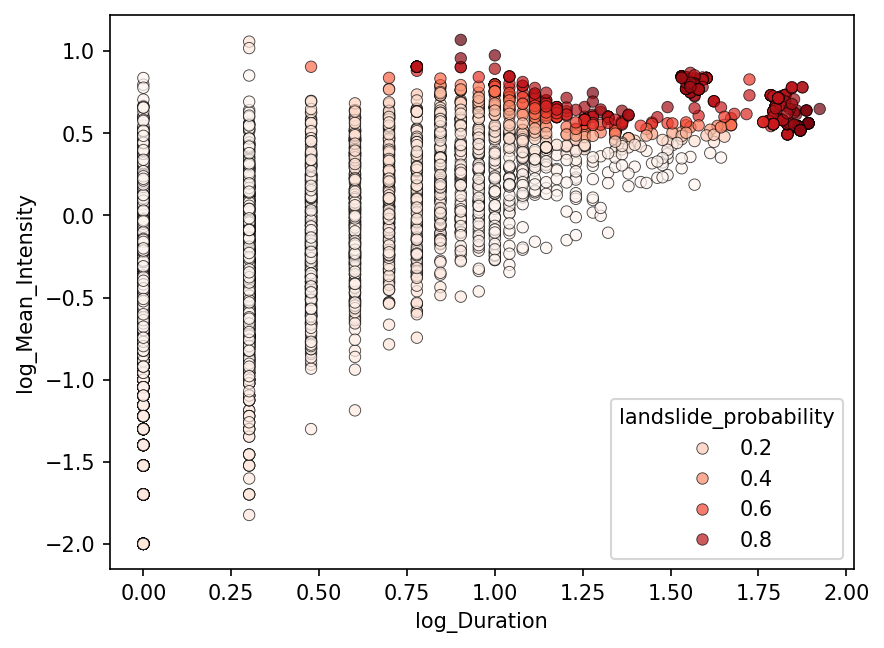

In [ ]:
plt.figure(dpi=150)
sns.scatterplot(df, x="log_Duration", y="log_Mean_Intensity", hue="landslide_probability", palette="Reds",
                edgecolor="k", alpha=0.7, s=30);

In [ ]:
# Saving the model
with open('svm_model.pkl', 'wb') as fp:
  pickle.dump(model, fp)

In [ ]:
model2 = pickle.load(open('svm_model.pkl', 'rb'))
model2

SVC(C=87.18672391214815, gamma=1.6975125993818487, probability=True,
    random_state=0)